In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.tsa.api import VAR
from datetime import datetime, timedelta

def download_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data.dropna()

def johansen_test(data):
    result = coint_johansen(data, det_order=1, k_ar_diff=10)
    trace_statistic = result.lr1
    critical_values = result.cvt
    
    return {
        'trace_statistic': trace_statistic,
        'critical_values': critical_values,
        'cointegration_rank': sum(t_stat > cv[1] for t_stat, cv in zip(trace_statistic, critical_values))
    }

def engle_granger_test(y, x):
    result = coint(y, x,trend='ct')
    return {
        'test_statistic': result[0],
        'p_value': result[1],
        'critical_values': result[2],
        'cointegrated': result[1] < 0.055
    }

def granger_causality(y, x, max_lag=10):
    data = pd.concat([y, x], axis=1)
    result = grangercausalitytests(data, maxlag=max_lag, verbose=False)
    
    min_p_value = min(result[i+1][0]['ssr_ftest'][1] for i in range(max_lag))
    f_statistics = {i+1: result[i+1][0]['ssr_ftest'][0] for i in range(max_lag)}
    p_values = {i+1: result[i+1][0]['ssr_ftest'][1] for i in range(max_lag)}
    
    return {
        'min_p_value': min_p_value,
        'f_statistics': f_statistics,
        'p_values': p_values,
        'causality': min_p_value < 0.055
    }

def analyze_pair(bitcoin, other_asset, period):
    # Johansen test
    johansen_result = johansen_test(pd.concat([bitcoin, other_asset], axis=1))
    
    # Engle-Granger test
    eg_result = engle_granger_test(bitcoin, other_asset)
    
    # Granger causality test
    bitcoin_stationary = bitcoin.diff().dropna()
    asset_stationary = other_asset.diff().dropna()
    granger_result = granger_causality(bitcoin_stationary, asset_stationary)
    
    return {
        'period': period,
        'johansen_test': johansen_result,
        'engle_granger_test': eg_result,
        'granger_causality_test': granger_result
    }

# List of assets to analyze
assets = {
    'S&P 500': '^GSPC',
    'Nasdaq': '^IXIC',
    'Dow Jones': '^DJI',
    'Russell 2000': '^RUT',
    'Gold': 'GC=F',
    'Silver': 'SI=F',
    'Crude Oil': 'CL=F',
    'EUR/USD': 'EURUSD=X',
    'Apple': 'AAPL',
    'Tesla': 'TSLA',
    'VIX': '^VIX',
    'DXY':'DXY',
    'Ethereum': 'ETH-USD',
    'iShares U.S. Real Estate ETF': 'IYR',
    'ETFMG Prime Cyber Security ETF': 'HACK',
    'iShares Global Clean Energy ETF': 'ICLN',
    'iShares ESG Aware MSCI USA ETF': 'ESGU'
    
}

# Analyze for two 5-year periods
end_date = datetime.now()
start_date_second_period = end_date - timedelta(days=365*5)
start_date_first_period = start_date_second_period - timedelta(days=365*5)

results = {}

for asset_name, ticker in assets.items():
    print(f"Analyzing {asset_name}...")
    asset_results = []
    
    for period_start, period_end, period_name in [
        (start_date_first_period, start_date_second_period, "First 5 years"),
        (start_date_second_period, end_date, "Second 5 years")
    ]:
        # Download data for the specific period
        data = download_data(['BTC-USD', ticker], period_start, period_end)
        
        if len(data) < 200:  # Skip if not enough data points
            continue
        
        bitcoin = data['BTC-USD']
        asset_data = data[ticker]
        
        result = analyze_pair(bitcoin, asset_data, period_name)
        asset_results.append(result)
    
    results[asset_name] = asset_results

# Print detailed results
for asset_name, asset_results in results.items():
    print(f"\nDetailed results for {asset_name}:")
    for result in asset_results:
        print(f"\n{result['period']}:")
        
        print("Johansen Test:")
        print(f"  Trace Statistics: {result['johansen_test']['trace_statistic']}")
        print(f"  Critical Values: {result['johansen_test']['critical_values']}")
        print(f"  Cointegration Rank: {result['johansen_test']['cointegration_rank']}")
        
        print("\nEngle-Granger Test:")
        print(f"  Test Statistic: {result['engle_granger_test']['test_statistic']:.4f}")
        print(f"  P-value: {result['engle_granger_test']['p_value']:.4f}")
        print(f"  Critical Values: {result['engle_granger_test']['critical_values']}")
        print(f"  Cointegrated: {result['engle_granger_test']['cointegrated']}")
        
        print("\nGranger Causality Test:")
        print(f"  Minimum P-value: {result['granger_causality_test']['min_p_value']:.4f}")
        print(f"  F-statistics: {result['granger_causality_test']['f_statistics']}")
        print(f"  P-values: {result['granger_causality_test']['p_values']}")
        print(f"  Causality: {result['granger_causality_test']['causality']}")


Analyzing S&P 500...


[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['^GSPC', 'BTC-USD']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Analyzing Nasdaq...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Analyzing Dow Jones...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed

Analyzing Russell 2000...



/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed

Analyzing Gold...



/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[                       0%                       ]

Analyzing Silver...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed

Analyzing Crude Oil...



/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Analyzing EUR/USD...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Analyzing Apple...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[                       0%                       ]

Analyzing Tesla...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[                       0%                       ]

Analyzing VIX...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed

Analyzing DXY...



/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


Analyzing Ethereum...


/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Analyzing iShares U.S. Real Estate ETF...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[                       0%                       ]

Analyzing ETFMG Prime Cyber Security ETF...


[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed

Analyzing iShares Global Clean Energy ETF...



/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed

Analyzing iShares ESG Aware MSCI USA ETF...



/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
[*********************100%***********************]  2 of 2 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



Detailed results for S&P 500:

Second 5 years:
Johansen Test:
  Trace Statistics: [22.8736311   2.52011545]
  Critical Values: [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]]
  Cointegration Rank: 1

Engle-Granger Test:
  Test Statistic: -4.0594
  P-value: 0.0231
  Critical Values: [-4.33994441 -3.78815583 -3.5019574 ]
  Cointegrated: True

Granger Causality Test:
  Minimum P-value: 0.5337
  F-statistics: {1: 9.49414334086684e-06, 2: 0.050975601489710046, 3: 0.1608272030902764, 4: 0.11534748984474279, 5: 0.47067522641170795, 6: 0.8468478630407449, 7: 0.6740535885610657, 8: 0.5758614392629547, 9: 0.5901012922175989, 10: 0.5959076895741573}
  P-values: {1: 0.9975420079334367, 2: 0.9503038347559927, 3: 0.922701107063802, 4: 0.9771230201963134, 5: 0.7983058314379086, 6: 0.5337380988772287, 7: 0.6942214680434919, 8: 0.7983816756745953, 9: 0.8060714168471395, 10: 0.8182769258501998}
  Causality: False

Detailed results for Nasdaq:

First 5 years:
Johansen Test:
  Trace Statistics: [2

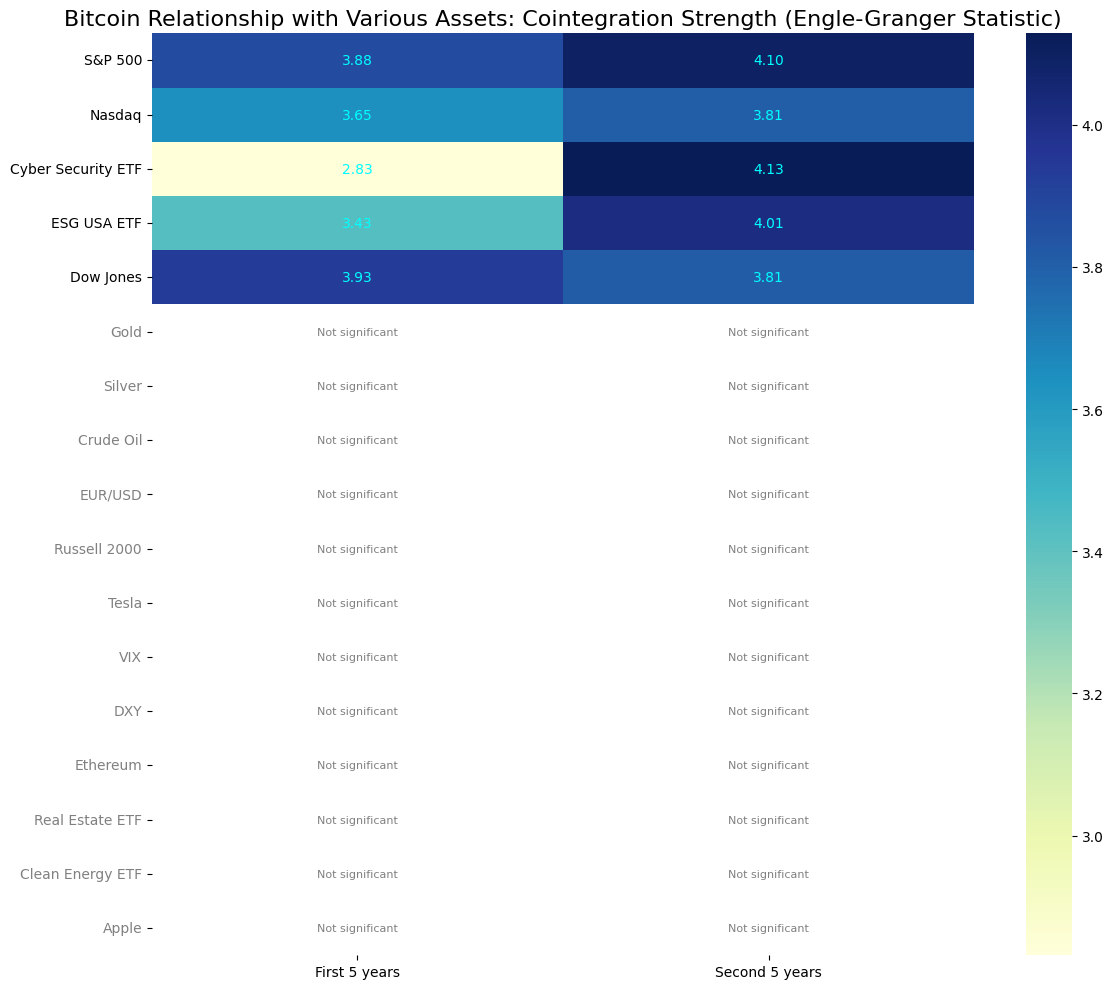

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Создаем DataFrame с абсолютными значениями статистики Энгла-Грейнджера
data = {
    'Asset': ['S&P 500', 'Nasdaq', 'Dow Jones', 'Russell 2000', 'Gold', 'Silver', 'Crude Oil', 'EUR/USD', 'Apple', 'Tesla', 'VIX', 'DXY','Ethereum', 'Real Estate ETF', 'Cyber Security ETF', 'Clean Energy ETF', 'ESG USA ETF'],
    'Engle_Granger_1': [3.8755, 3.6459, 3.9348, 3.3645, 2.7815, 2.7325, 3.3514, 3.5083, 2.9445, 2.8942, 2,3122,3.3167, 2.7011, 2.8315, 2.9012, 3.4276],
    'Engle_Granger_2': [4.0964, 3.8061, 3.8119, 3.0616, 2.1209, 2.6088, 2.0179, 2.4336, 3.8061, 1.8264, 1.8901, 1.9233, 2.0177, 2.5276, 4.1288, 2.0664, 4.0126],
    'Significant': [True, True, True, False, False, False, False, False, False, False, False, False, False, False, True, False, True]
}

df = pd.DataFrame(data)

# Сортируем DataFrame, чтобы значимые результаты были сверху
df = df.sort_values('Significant', ascending=False)

# Создаем маску для незначимых результатов
mask = ~df['Significant'].values[:, np.newaxis].repeat(2, axis=1)

# Создаем график
plt.figure(figsize=(12, 10))

# Создаем тепловую карту
ax = sns.heatmap(df[['Engle_Granger_1', 'Engle_Granger_2']], 
                 annot=True, fmt='.2f', cmap='YlGnBu', cbar=True, 
                 xticklabels=['First 5 years', 'Second 5 years'],
                 yticklabels=df['Asset'],
                 mask=mask,annot_kws={'color': 'white'})

# Добавляем белый слой для незначимых результатов
sns.heatmap(df[['Engle_Granger_1', 'Engle_Granger_2']], 
            annot=True, fmt='.2f', cmap='Greys', cbar=False, 
            xticklabels=['First 5 years', 'Second 5 years'],
            yticklabels=df['Asset'],
            mask=~mask, ax=ax, alpha=0,annot_kws={'color': 'white'})

# Изменяем цвет текста для незначимых результатов
for text, sig in zip(ax.texts, df['Significant'].repeat(2)):
    if not sig:
        text.set_text('Not significant')
        text.set_fontsize(8)
    text.set_color('gray' if not sig else 'cyan')

# Изменяем цвет названий активов для незначимых результатов
for i, sig in enumerate(df['Significant']):
    if not sig:
        ax.yaxis.get_ticklabels()[i].set_color('gray')

plt.title('Bitcoin Relationship with Various Assets: Cointegration Strength (Engle-Granger Statistic)', fontsize=16)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/work/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

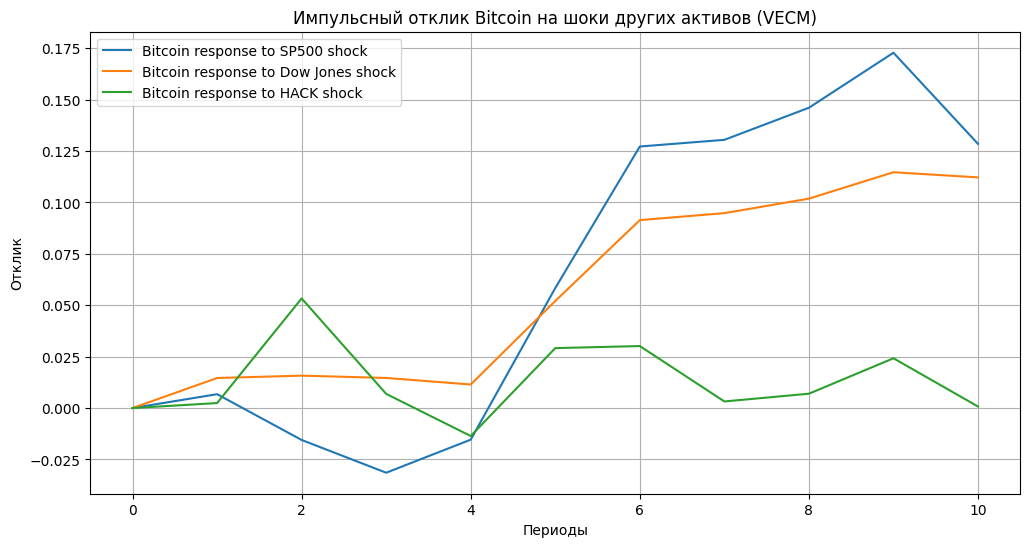

Корреляции между активами:
SP500        0.874283
Bitcoin      1.000000
Dow Jones    0.849623
HACK         0.891741
Name: Bitcoin, dtype: float64


In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Загрузка данных
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data['Close'].rename(ticker)

start_date = '2019-09-01'
end_date = '2024-09-29'

sp500 = download_data('^GSPC', start_date, end_date)
bitcoin = download_data('BTC-USD', start_date, end_date)
dow_jones = download_data('^DJI', start_date, end_date)
hack = download_data('HACK', start_date, end_date)

# Объединение данных
data = pd.concat([sp500, bitcoin, dow_jones, hack], axis=1)
data.columns = ['SP500', 'Bitcoin', 'Dow Jones', 'HACK']

# Нормализация данных
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
data_scaled = data_scaled.dropna()

# Функция для проверки коинтеграции
def check_cointegration(y, x):
    _, pvalue, _ = coint(y, x,trend='ct')
    return pvalue < 0.05

# Функция для получения IRF для пары активов с использованием VECM
def get_irf_vecm(data, asset1, asset2, periods=10):
    pair_data = data[[asset1, asset2]]
    
    # Проверка коинтеграции
    if check_cointegration(pair_data[asset1], pair_data[asset2]):
        model = VECM(pair_data, k_ar_diff=10, coint_rank=2 ,deterministic="li")
        results = model.fit()
        
        irf = results.irf(periods)
        return irf.irfs[:, 1, 0]  # Отклик asset2 на шок asset1
    else:
        print(f"Нет коинтеграции между {asset1} и {asset2}")
        return np.zeros(periods)

# Получение IRF для каждой пары
irf_sp500 = get_irf_vecm(data_scaled, 'SP500', 'Bitcoin')
irf_dow = get_irf_vecm(data_scaled, 'Dow Jones', 'Bitcoin')
irf_hack = get_irf_vecm(data_scaled, 'HACK', 'Bitcoin')

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(range(len(irf_sp500)), irf_sp500, label='Bitcoin response to SP500 shock')
plt.plot(range(len(irf_dow)), irf_dow, label='Bitcoin response to Dow Jones shock')
plt.plot(range(len(irf_hack)), irf_hack, label='Bitcoin response to HACK shock')
plt.title('Impulse response Bitcoin to assets shock (VECM)')
plt.xlabel('Trading days')
plt.ylabel('Reponse')
plt.legend()
plt.grid(True)
plt.show()

# Вывод корреляций между активами
print("Корреляции между активами:")
print(data.corr()['Bitcoin'])
